# torchkeras.KerasModel wandb Demo

You can install torchkeras using pip:
`pip install torchkeras`

Here is a mnist cnn example using torchkeras.KerasModel  with visualization of wandb.


`pip install wandb`


Before you start run this demo, you should first create an account at wandb website  https://wandb.ai/ ,

and get your API keys from the settings page。

You can explore the wandb dashboard created in this demo from the url below:

https://wandb.ai/lyhue1991/mnist_torchkeras


In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lyhue1991. Use `wandb login --relogin` to force relogin


True

In [3]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

import torchkeras #Attention this line 
print(torchkeras.__version__)

3.9.3


## 0, set hyperparameters 

In [4]:
from argparse import Namespace
config = Namespace(
    batch_size = 256,
    lr = 1e-3,
    dropout_p = 0.1,
    )

## 1, prepare data 

In [5]:
import torchvision 
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)
dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=config.batch_size, shuffle=True, num_workers=2)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=config.batch_size, shuffle=False, num_workers=2)


In [11]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)


torch.Size([256, 1, 28, 28])
torch.Size([256])


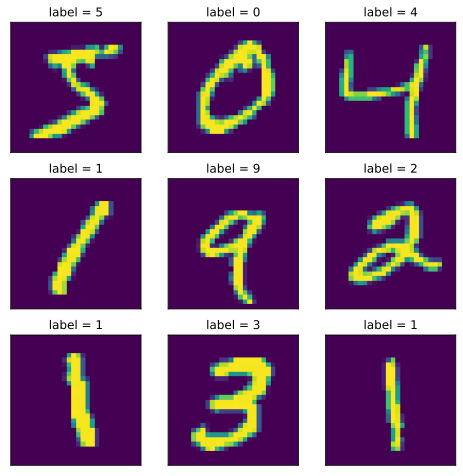

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#visual some samples
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()



## 2, create the  model

In [13]:
def create_net(config):
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = config.dropout_p))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

net = create_net(config)

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total
        
        

In [14]:
model = torchkeras.KerasModel(net,
      loss_fn = nn.CrossEntropyLoss(),
      optimizer= torch.optim.Adam(net.parameters(),lr=0.001),
      metrics_dict = {"acc":Accuracy()},
    )

from torchkeras import summary
summary(model,input_data=features);



--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 26, 26]                  320
MaxPool2d-2                         [-1, 32, 13, 13]                    0
Conv2d-3                              [-1, 64, 9, 9]               51,264
MaxPool2d-4                           [-1, 64, 4, 4]                    0
Dropout2d-5                           [-1, 64, 4, 4]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                   [-1, 10]                  330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
-----------------------------------------

## 3, train the model

<<<<<< 🚀 mps is used >>>>>>


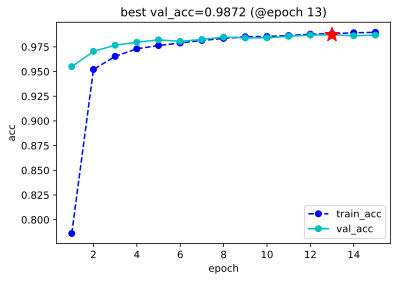

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_val_acc,▁▄▆▆▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▇▇▇███████████
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇█▇▇█████
val_loss,█▅▃▃▂▂▂▁▂▂▁▁▁▁▁
best_score,0.9872
best_val_acc,0.9872
epoch,15.0
lr,0.001


In [16]:
from torchkeras.kerascallbacks import WandbCallback

wandb_cb = WandbCallback(project='mnist_torchkeras',
                         config=config,
                         name=None,
                         save_code=True,
                         save_ckpt=True)

dfhistory=model.fit(train_data=dl_train, 
                    val_data=dl_val, 
                    epochs=15, 
                    patience=5, 
                    monitor="val_acc",
                    mode="max",
                    ckpt_path='checkpoint.pt',
                    callbacks = [wandb_cb]
                   )


## 4,  monitor from wandb

Now you can track your model training in your wandb project website.

![](./data/wandb_charts.png)

![](./data/wandb_media.png)

You can restructure the wandb dashboard by  add or delete or drag panel/sections.

Actually you can do many visualization jobs in the wandb dashboard interactively without writing code.

Just explore it!

Here we create a panel to show the best score during training.

![](./data/wandb_metric.png)



## 5，analysis cases

we can also resume the  finished wandb run and log more data to it.

Here we use the wandb.Table to do case analysis in the dashboard.



In [29]:
#resume the run 
import wandb 
run = wandb.init(project='mnist_torchkeras', id=model.run_id, resume='must')


best_score,0.9884
best_val_acc,0.9884
epoch,15
lr,0.001
train_acc,0.98763
train_loss,0.03697
val_acc,0.9884
val_loss,0.03976


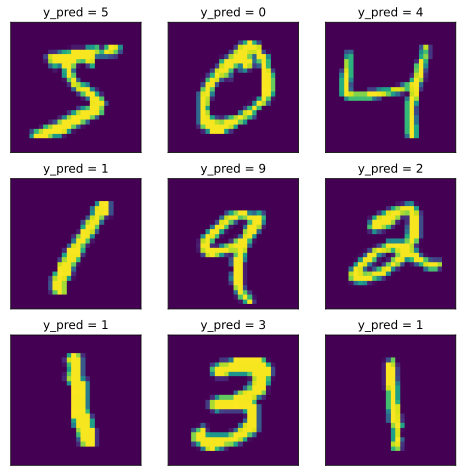

In [30]:
# visual the  prediction
device = None
for p in model.parameters():
    device = p.device
    break

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    tensor = img.to(device)
    y_pred = torch.argmax(net(tensor[None,...])) 
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("y_pred = %d"%y_pred)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()    


In [31]:
def data2fig(data):
    fig = plt.Figure()
    ax = fig.add_subplot()
    ax.imshow(data)
    ax.set_xticks([])
    ax.set_yticks([]) 
    return fig

def fig2img(fig):
    import io,PIL
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img


In [32]:
from tqdm import tqdm 
good_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])
bad_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])


In [33]:
for i in tqdm(range(1000)):
    features,label = ds_val[i]
    tensor = features.to(device)
    y_pred = torch.argmax(net(tensor[None,...])) 
    
    # log badcase
    if y_pred!=label:
        if len(bad_cases.data)<20:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            bad_cases.add_data(input_img,label,y_pred)
            
    # log goodcase
    else:
        if len(good_cases.data)<20:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            good_cases.add_data(input_img,label,y_pred)
            

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 562.56it/s]


In [34]:
wandb.log({'good_cases':good_cases,'bad_cases':bad_cases})

![](./data/wandb_tables.png)

## 6, save dataset/code/model


We can also save the code and dataset using wandb.save or wandb.log_artifact.

The differences of wandb.save and wandb.log_artifact are these:

wandb.save will copy the file to wandb's run log dir and the saved file belongs to the run, 

while wandb.log_artifact will not copy the file/directory to wandb's run log dir and the saved file/directory belongs to the project and has .

PS: The weight checkpoint file checkpoint.pt has been saved by wandbCallback ealier.


In [35]:
#save our dataset 
arti_dataset = wandb.Artifact('mnist', type='dataset')
arti_dataset.add_dir('mnist/')
wandb.log_artifact(arti_dataset)

wandb: Adding directory to artifact (./mnist)... Done. 0.1s


In [36]:
!ls 

1，kerasmodel_example.ipynb           checkpoint.pt
2，kerasmodel_wandb_demo.ipynb        data
3，kerasmodel_tuning_demo.ipynb       dist
4，kerasmodel_tensorboard_demo.ipynb  mnist
5，kerasmodel_ddp_tpu_examples.ipynb  push2github.md
6，lightmodel_example.ipynb           setup.py
7，lightmodel_tensorboard_demo.ipynb  torchkeras
LICENSE                               torchkeras.egg-info
README.md                             training.log
build                                 wandb


In [37]:
#save the code

arti_code = wandb.Artifact('ipynb', type='code')
arti_code.add_file("2，kerasmodel_wandb_demo.ipynb")
wandb.log_artifact(arti_code)

#wandb.save("2，kerasmodel_wandb_demo.ipynb")


In [38]:
#save the model

arti_model = wandb.Artifact('checkpoint', type='model')
arti_model.add_file(model.ckpt_path)
wandb.log_artifact(arti_model)


In [39]:
wandb.finish()

best_score,0.9884
best_val_acc,0.9884
epoch,15
lr,0.001
train_acc,0.98763
train_loss,0.03697
val_acc,0.9884
val_loss,0.03976


Now we can download the best model weight

In [153]:
import pandas as pd 
import wandb
api = wandb.Api()
    
entity, project = "lyhue1991", "mnist_torchkeras"  # set to your entity and project 

def get_best_run_id(entity,project,metric_mode=model.mode):
    runs = api.runs(entity + "/" + project) 
    data = []
    for run in runs:
        run_info = {'run_id':run.id,'run_name':run.name,'best_score':run.summary['best_score']}
        run_config = {k: v for k,v in run.config.items() if not k.startswith('_')}
        run_info.update(run_config)
        data.append(run_info)
    dfruns = pd.DataFrame(data) 
    dfruns.sort_values(by = 'best_score', 
                   ascending= False if metric_mode=='max' else True,
                   inplace = True)
    best_run_id = dfruns['run_id'].iloc[0]
    return best_run_id 

def get_model_versions(entity,project):
    model_versions = api.artifact_versions('model',
        name = entity + "/" + project+'/' + 'checkpoint')
    return [x.version for x in model_versions]


In [120]:
best_run_id = get_best_run_id(entity,project)
print(best_run_id)

2a61qmcd


In [157]:
model_versions = get_model_versions(entity,project)
print(model_versions)


['v2', 'v1', 'v0']


In [158]:
best_run = api.run(path= entity + "/" + project+'/'+ best_run_id)

In [160]:
best_model_arti = None
for arti in best_run.logged_artifacts():
    if arti.type=='model':
        best_model_arti = arti

print(best_model_arti.version) 

best_model_arti.download(root='best_ckpt')
